# Sentiment Analysis for Amazon Review

## Import Libaries

In [278]:
import warnings

#Ignoring unnecessory warnings
warnings.filterwarnings("ignore")                   

#for large and multi-dimensional arrays
import numpy as np
#for data manipulation and analysis
import pandas as pd

import plotly.express as px
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
#for model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas_profiling import ProfileReport

# Pretty table - visual
from tabulate import tabulate
from prettytable import PrettyTable

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yayua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Base Info from dataset

In [279]:
##reading dataset
df = pd.read_csv('Reviews.csv')
print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [280]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

#### Checking stat table

In [281]:
df.describe().style.background_gradient(cmap='cividis')

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000
mean,284227.500000,1.743817,2.228810,4.183199,1296256604.902420
std,164098.679298,7.636513,8.289740,1.310436,48043312.332415
min,1.000000,0.000000,0.000000,1.000000,939340800.000000
25%,142114.250000,0.000000,0.000000,4.000000,1271289600.000000
50%,284227.500000,0.000000,1.000000,5.000000,1311120000.000000
75%,426340.750000,2.000000,2.000000,5.000000,1332720000.000000
max,568454.000000,866.000000,923.000000,5.000000,1351209600.000000


#### Checking Data type of features

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


#### Total unique values in each column

In [283]:
dict={}
for i in df.columns:
    dict[i]=df[i].value_counts().shape[0]
    
pd.DataFrame(dict,index=['Unique']).T.style.background_gradient(cmap='cividis')

,Unique
Id,568454
ProductId,74258
UserId,256059
ProfileName,218416
HelpfulnessNumerator,231
HelpfulnessDenominator,234
Score,5
Time,3168
Summary,295742
Text,393579


#### Checking missing values

In [284]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    Percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, Percentage], axis=1, keys=['Total', 'Percentage'])
missing_data(df)[missing_data(df)['Percentage']!=0].style.background_gradient(cmap='cividis')

,Total,Percentage
Summary,27,0.004750
ProfileName,16,0.002815


#### Target score

In [285]:
df['Score'].value_counts()

def score_distribution(df):
    distribution = df['Score'].value_counts(ascending = False)
    return pd.concat([distribution], axis=1, keys=['Number of Count'])
score_distribution(df)[score_distribution(df)['Number of Count']!=0].style.background_gradient(cmap='cividis')

,Number of Count
5,363122
4,80655
1,52268
3,42640
2,29769


In [286]:
vc = df['Score'].value_counts().to_frame().reset_index()
fig = px.bar(x=vc["Score"], y=vc["index"], orientation='h',color=vc['index'],labels=True,color_continuous_scale="cividis")
fig.update_layout(title = "<b> Distribution Of The Score </b>",xaxis_title="",yaxis_title="<b> Frequency </b> ",font_size=18, plot_bgcolor="#fff",showlegend=False) 

<AxesSubplot:>

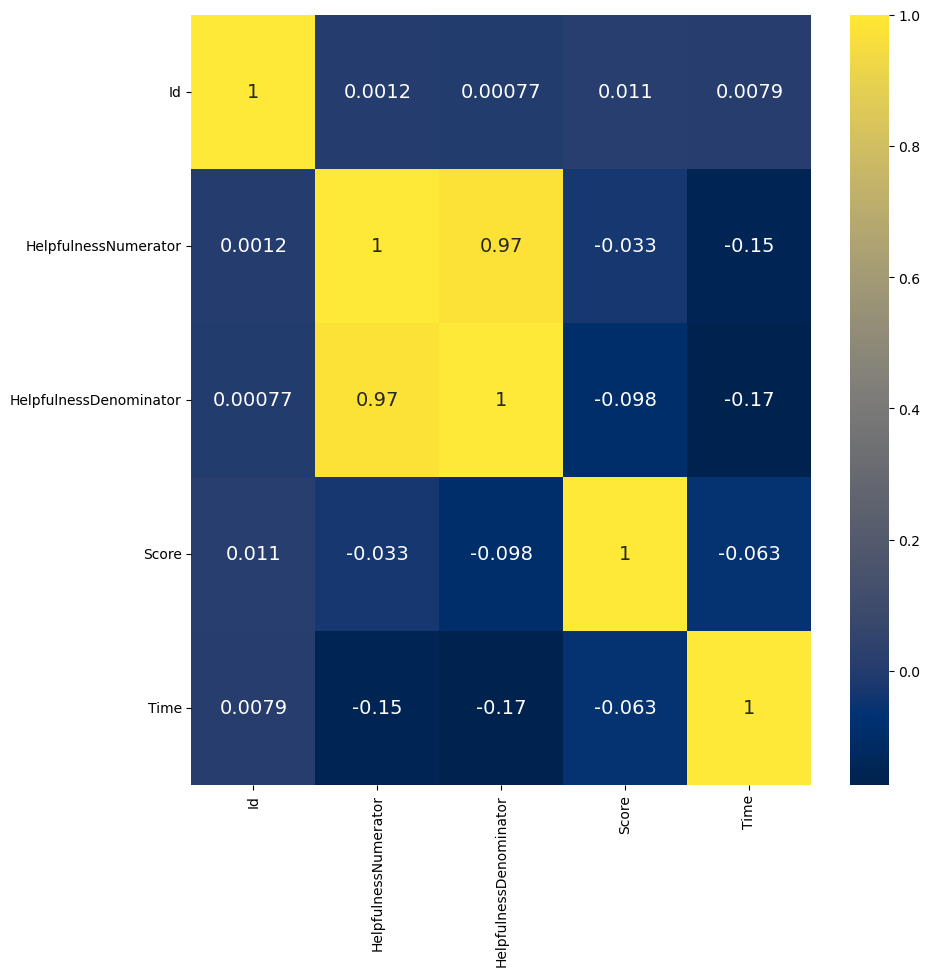

In [287]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="cividis", annot_kws={"size":14})

# Performing Data Pre-Processing
## NLP - convert text into vectors
#### Adding new column for helpful% - helpfulnessnumerator/helpfulnessdenominator

In [288]:
df['Helpful %'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0


In [289]:
df['Helpful %'].unique()

array([ 1.        , -1.        ,  0.8       ,  0.        ,  0.5       ,
        0.66666667,  0.25      ,  0.89473684,  0.83333333,  0.75      ,
        0.33333333,  0.3       ,  0.11111111,  0.42857143,  0.875     ,
        0.85714286,  0.2       ,  0.26315789,  0.6       ,  0.71428571,
        0.53846154,  0.57142857,  0.91489362,  0.86666667,  0.82352941,
        0.78571429,  0.74074074,  0.4       ,  0.375     ,  0.28571429,
        0.14285714,  0.77777778,  0.125     ,  0.9       ,  0.94117647,
        0.92307692,  0.7       ,  0.45454545,  0.88888889,  0.83870968,
        0.9047619 ,  0.92857143,  0.90909091,  0.91666667,  0.84615385,
        0.10526316,  0.98214286,  0.97826087,  0.7518797 ,  0.3125    ,
        0.1       ,  0.18518519,  0.88      ,  0.69230769,  0.625     ,
        0.54545455,  0.41666667,  0.45833333,  0.22222222,  0.81818182,
        0.8125    ,  0.16666667,  0.93103448,  0.88235294,  0.23529412,
        0.63636364,  0.81481481,  0.95652174,  0.64285714,  0.58

#### Cutting the data into slices & into some bins

In [290]:
pd.cut(df['Helpful %'] , bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])

0         80-100%
1             NaN
2         80-100%
3         80-100%
4             NaN
           ...   
568449        NaN
568450        NaN
568451    80-100%
568452    80-100%
568453        NaN
Name: Helpful %, Length: 568454, dtype: category
Categories (6, object): ['Empty' < '0-20%' < '20-40%' < '40-60%' < '60-80%' < '80-100%']

#### Adding new column for upvote metrics

In [291]:
df['%upvote'] = pd.cut( df['Helpful %'] , bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


#### Data count based on score as category and %upvote as subcategory - only ID column
#### Assigning different different labels to helpful% according to its value

In [292]:
df.groupby(['Score', '%upvote']).agg({'Id':'count'})

Id
Score %upvote        
1     Empty      8060
      0-20%      2338
      20-40%     4649
      40-60%     6586
      60-80%     5838
      80-100%   12531
2     Empty      4234
      0-20%       762
      20-40%     1618
      40-60%     3051
      60-80%     2486
      80-100%    7014
3     Empty      5062
      0-20%       474
      20-40%     1506
      40-60%     3384
      60-80%     2754
      80-100%   11037
4     Empty      4780
      0-20%       116
      20-40%      909
      40-60%     3185
      60-80%     2941
      80-100%   26707
5     Empty     11638
      0-20%       432
      20-40%     2275
      40-60%    10312
      60-80%    11060
      80-100%  140661

##### - Organizing the above table

In [293]:
df_s2=df.groupby(['Score', '%upvote']).agg({'Id':'count'}).reset_index()
df_s2

,Score,%upvote,Id
0,1,Empty,8060
1,1,0-20%,2338
2,1,20-40%,4649
3,1,40-60%,6586
4,1,60-80%,5838
5,1,80-100%,12531
6,2,Empty,4234
7,2,0-20%,762
8,2,20-40%,1618
9,2,40-60%,3051


#### Creating Pivot Table for better conclusion

In [294]:
df_s2.pivot(index='%upvote',columns='Score')

Id                            
Score        1     2      3      4       5
%upvote                                   
Empty     8060  4234   5062   4780   11638
0-20%     2338   762    474    116     432
20-40%    4649  1618   1506    909    2275
40-60%    6586  3051   3384   3185   10312
60-80%    5838  2486   2754   2941   11060
80-100%  12531  7014  11037  26707  140661

#### Creating heatmap for Pivot Table

Text(0.5, 1.0, 'How helpful users find among user scores')

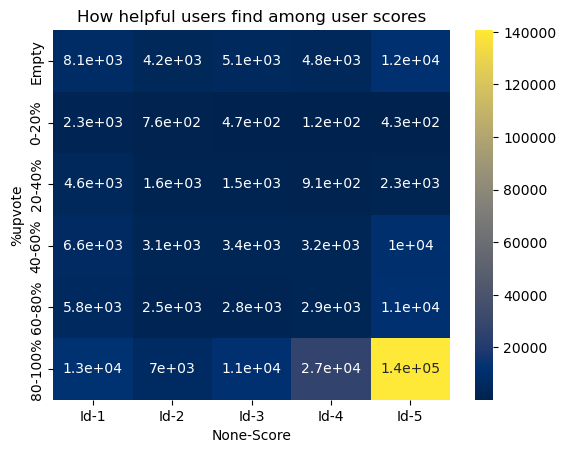

In [295]:
sns.heatmap(df_s2.pivot(index='%upvote',columns='Score'),annot=True,cmap = 'cividis')
plt.title('How helpful users find among user scores')

##### Key message from above:
- Reviews are skewed towards positive
- More than half of the reviews are with zero votes
- Many people agree with score 5 reviews

### Removing -

#### Removing the Duplicates if any

In [296]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

#### Lower Casing

In [297]:
df['Text'] = df['Text'].str.lower()
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price. there was a wid...,-1.0,NaN


#### Remove punctuation - !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~

In [298]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['Text'] = df['Text'].apply(lambda text: remove_punctuation(text))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide...,-1.0,NaN


#### Removing Stopwords

In [299]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['Text'] = df['Text'].apply(lambda text: remove_stopwords(text))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around centuries light pillowy citr...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...,-1.0,NaN


#### Removing urls

In [300]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df['Text'] = df['Text'].apply(lambda text: remove_urls(text))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around centuries light pillowy citr...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...,-1.0,NaN


#### Reading the dataset again before next step

In [301]:
df.shape

(568454, 12)

In [302]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around centuries light pillowy citr...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...,-1.0,NaN


In [303]:
df['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [304]:
df2 = df[df['Score'] != 3]
X = df2['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df2['Score'].map(y_dict)

# Model

#### Fitting the Model

In [305]:
c = CountVectorizer(stop_words = 'english')

In [306]:
X_c = c.fit_transform(X)

In [307]:
print('features: {}'.format(X_c.shape[1]))

features: 227073


In [308]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y)
print(' train records: {}'.format(X_train.shape[0]))

 train records: 394360


In [309]:
log=LogisticRegression()

In [310]:
ml =log.fit(X_train, y_train)
acc = ml.score(X_test, y_test)
print ('Model Accuracy: {}'.format(acc))

Model Accuracy: 0.9390052794133309


# Word Cloud
#### Fetching Top 20 Positive & Top 20 Negative words

In [311]:
w = c.get_feature_names()
w

['00',
 '000',
 '0000',
 '000001',
 '00001',
 '000013',
 '00004br',
 '0000soo',
 '0001',
 '000100z',
 '0001br',
 '0004',
 '0009',
 '000br',
 '001',
 '0010',
 '00100',
 '00127',
 '00128',
 '00129',
 '00130',
 '00131',
 '00132',
 '00134',
 '00136',
 '00139',
 '0014br',
 '0014mg',
 '0015br',
 '0016',
 '0019br',
 '002',
 '0020',
 '002027c',
 '0025br',
 '0028br',
 '003',
 '0030',
 '0030br',
 '0032',
 '0032br',
 '0035',
 '0035ounce',
 '00373br',
 '00377br',
 '0039',
 '003packet',
 '004',
 '0040',
 '00439',
 '0043bag',
 '0048br',
 '00493a',
 '0049br',
 '004oz',
 '004ozbr',
 '005',
 '0050',
 '0050br',
 '0051br',
 '0052br',
 '00533aand',
 '0055',
 '0059',
 '005br',
 '005oz',
 '006',
 '0060',
 '0061br',
 '0063br',
 '0064',
 '0065br',
 '0066',
 '00688',
 '0069615br',
 '006g',
 '006ounce',
 '007',
 '00703',
 '00704',
 '0075',
 '00768ppm',
 '007ounce',
 '008',
 '0080br',
 '0088br',
 '0089br',
 '008bag',
 '008y4',
 '009',
 '0090br',
 '0091',
 '0095',
 '0097',
 '0098',
 '009br',
 '009mg',
 '009packet

In [312]:
coef = ml.coef_.tolist()[0]
coef

[0.2400400160484983,
 0.034595881913821507,
 -0.026679335150076304,
 -0.027701881780574797,
 0.0,
 0.0,
 -0.01871592278232094,
 0.0002937631146290456,
 0.0,
 -0.029496208658653083,
 -0.02129709979887247,
 0.04148418598576476,
 0.0049020167506356035,
 -0.06351471733534034,
 -0.20878123569622498,
 -0.013339667575038152,
 0.015581832534190855,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 0.04092797244756639,
 -0.018662096236540193,
 0.0,
 5.382654578073427e-05,
 -0.004588086791965824,
 5.382654578073427e-05,
 -0.2945750965262213,
 -0.013339667575038152,
 0.2361619827922804,
 0.006864478733763376,
 5.382654578073427e-05,
 0.003267951126604438,
 -0.017927754367004074,
 0.00010765309156146854,
 -0.07284208298997724,
 5.382654578073427e-05,
 0.0,
 -0.01076484782137606,
 -0.01871592278232094,
 -0.01871592278232094,
 0.0,
 -0.14377444159779645,
 4.4381199936555404e

In [313]:
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df

,Word,Coefficient
0,00,0.240040
1,000,0.034596
2,0000,-0.026679
3,000001,-0.027702
4,00001,0.000000
...,...,...
227068,çaykur,0.000000
227069,çelem,-0.207116
227070,être,0.030466
227071,île,0.000000


In [314]:
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'],ascending=False)
coeff_df

,Word,Coefficient
67155,downside,4.038977
157477,pleasantly,3.578166
14888,addicting,2.907093
223539,worries,2.722353
171279,resist,2.471782
...,...,...
60418,defeats,-2.981301
177978,schar,-2.998371
71211,embarrassed,-3.002553
60074,deceptive,-3.205291


In [315]:
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('\n')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))

-Top 20 positive-
       Word  Coefficient
   downside     4.038977
 pleasantly     3.578166
  addicting     2.907093
    worries     2.722353
     resist     2.471782
  perfectbr     2.453821
    easiest     2.402521
   drawback     2.390583
   obsessed     2.349028
  skeptical     2.341225
     hooked     2.268699
 hesitation     2.252743
     delish     2.241966
     solved     2.237579
    trainer     2.175028
   relaxing     2.172495
    dieters     2.167948
chocolately     2.161281
   thankful     2.154728
   tastiest     2.125783


-Top 20 negative-
          Word  Coefficient
    terriblebr    -2.384423
         ruins    -2.410585
    overpowers    -2.426812
           ugh    -2.482004
      mediocre    -2.515840
     cancelled    -2.573929
disappointment    -2.650258
           ick    -2.740578
     redeeming    -2.746575
 dissapointing    -2.773967
         worst    -2.780524
 disappointing    -2.781774
    returnable    -2.785231
   unappealing    -2.837105
  unacceptable   

# Evaluate model
## Applying multiple NLP Techniques & Multiple ML algorithms
#### Creating a function

In [316]:
def text_fit(X, y, nlp_model,ml_model,coef_show=1):
    
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml =ml_model.fit(X_train, y_train)
    acc = ml.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = nlp_model.get_feature_names()
        coef = ml.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('\n')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('\n')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

In [317]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(stop_words = 'english')
from sklearn.linear_model import LogisticRegression

#### Fitting to model

In [318]:
text_fit(X, y, c, LogisticRegression())

features: 227073
 train records: 394360
 test records: 131454
Model Accuracy: 0.9387922771463783


-Top 20 positive-
       Word  Coefficient
 pleasantly     4.357895
   downside     3.959523
  addicting     3.340262
   drawback     3.095615
    worries     2.970248
    easiest     2.891577
     delish     2.820742
   obsessed     2.660533
     divine     2.588791
chocolately     2.540958
   soothing     2.509661
  perfectbr     2.502947
     hooked     2.477601
excellentbr     2.475852
    welcome     2.463927
    settled     2.435343
   tastiest     2.422844
       whim     2.405144
  skeptical     2.400208
    trainer     2.388058


-Top 20 negative-
         Word  Coefficient
   terriblebr    -2.751530
        schar    -2.797595
       ripoff    -2.808961
      allegro    -2.818117
        ruins    -2.867890
       lacked    -2.885782
disappointing    -2.895108
        lousy    -2.922697
        worst    -2.952930
      glowing    -2.974067
     mediocre    -2.985890
   overpowers 

#### Creating a prediction function

In [319]:
from sklearn.metrics import confusion_matrix,accuracy_score
def predict(X, y, nlp_model,ml_model):
    
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml =ml_model.fit(X_train, y_train)
    predictions=ml.predict(X_test)
    cm=confusion_matrix(predictions,y_test)
    print(cm)
    acc=accuracy_score(predictions,y_test)
    print(acc)

In [320]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(stop_words = 'english')
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [321]:
predict(X,y,c,lr)

features: 227073
 train records: 394360
 test records: 131454
[[ 15003   2486]
 [  5500 108465]]
0.9392487105755626


Accuracy is around 93.96%. Look great! However, I notice that some significant coefficients are not meaningful.

#### Calling function for dummy classifier

In [322]:
from sklearn.dummy import DummyClassifier
text_fit(X, y, c, DummyClassifier(),0)

features: 227073
 train records: 394360
 test records: 131454
Model Accuracy: 0.8429184353462048


#### Logistic regression model on TFIDF

In [323]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

features: 227073
 train records: 394360
 test records: 131454
Model Accuracy: 0.9358558887519589


-Top 20 positive-
      Word  Coefficient
     great    14.289092
 delicious    12.475956
      best    12.102762
   perfect    11.258012
 excellent     9.888044
     loves     9.663801
    highly     9.218852
      love     8.550390
 wonderful     8.512197
   amazing     8.115916
   awesome     7.928247
      good     7.631838
  favorite     7.226196
   pleased     7.156822
      nice     7.093360
    hooked     6.974443
     yummy     6.959818
pleasantly     6.704298
    smooth     6.543144
 fantastic     6.430743


-Top 20 negative-
          Word  Coefficient
          yuck    -5.779824
        hoping    -5.793518
   undrinkable    -5.855910
         waste    -5.999700
         worse    -6.263415
         bland    -6.428297
    disgusting    -6.434469
         stale    -6.440953
          weak    -6.696249
     tasteless    -6.699791
        return    -7.045196
         threw    -7.21

In [324]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english')
predict(X, y, tfidf, LogisticRegression())

features: 227073
 train records: 394360
 test records: 131454
[[ 14103   2171]
 [  6407 108773]]
0.9347452340742769


##### Accuracy is roughly the same - 93.47%. However I notice that the significant words make much more sense now, with higher coefficient magnitude as well!

#### Upvote Prediction
- I will focusing on score 5 reviews and remove neutral voted ones (score 3)

In [325]:
data = df[df['Score'] == 5]

In [326]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpful %', '%upvote'],
      dtype='object')

In [327]:
data2 = data[data['%upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
data2.shape

(154428, 12)

In [328]:
X = data2['Text']

In [329]:
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = data2['%upvote'].map(y_dict)

In [330]:
print(y.value_counts())

1.0    151721
0.0      2707
Name: %upvote, dtype: int64


#### The target class "y" is highly skewed, and I observed that positive votes are much higher than negative votes.
- So I will resample the data to get balanced data:

In [331]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()

In [332]:
X_c=tf.fit_transform(X)

In [333]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_c,y,train_size=0.7)

In [334]:
y_test.value_counts()

1.0    45516
0.0      813
Name: %upvote, dtype: int64

#### RandomOverSampler to handle imbalanced data

In [335]:
from imblearn.over_sampling import RandomOverSampler

In [336]:
os =  RandomOverSampler()

In [337]:
X_train_res, y_train_res = os.fit_sample(X_c, y)

In [338]:
X_train_res.shape,y_train_res.shape

((303442, 116610), (303442,))

In [339]:
from collections import Counter

In [340]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({1.0: 151721, 0.0: 2707})
Resampled dataset shape Counter({1.0: 151721, 0.0: 151721})


# Tweaking Parameters

In [341]:
log_class=LogisticRegression()

In [342]:
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}

In [343]:
from sklearn.model_selection import GridSearchCV

In [344]:
clf=GridSearchCV(estimator=log_class,param_grid=grid,cv=5,n_jobs=-1,scoring='f1_macro')
clf.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [345]:
print('In training set, I can get score of :',clf.best_score_,' using',clf.best_params_)

In training set, I can get score of : 0.9879728853520786  using {'C': 100.0, 'penalty': 'l2'}


In [346]:
y_pred=clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(f'In testing set, I can get the best accuracy is {accuracy_score(y_test,y_pred)}')

[[  813     0]
 [  249 45267]]
In testing set, I can get the best accuracy is 0.9946253966198277
